# Create and run a particle tracking

Project specific variables are imported in the model_spec.py and gen_mod_dict.py files that must be included in the notebook directory. The first first includes pathnames to data sources that will be different for each user. The second file includes a dictionary of model-specific information such as  cell size, default hydraulic parameter values, and scenario defintion (e.g. include bedrock, number of layers, etc.). There are examples in the repository. Run the following cells up to the "Run to here" cell to get a pull-down menu of models in the model_dict. Then, without re-running that cell, run all the remaining cells.  Re-running the following cell would re-set the model to the first one in the list, which you probably don't want. If you use the notebook option to run all cells below, it runs the cell you're in, so if you use that option, move to the next cell (below the pull-down menu of models) first.

In [1]:
__author__ = 'Jeff Starn'
%matplotlib notebook
from model_specs import *
from gen_mod_dict import *

import os, sys, csv
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from flopy.utils.postprocessing import get_water_table

from copy import deepcopy

import flopy.utils.binaryfile as bf
from flopy.utils import Util2d
from matplotlib import colors
import flopy as fp
import pandas as pd
# import ipyparallel as ipp
# from model_specs import *
# from gen_mod_dict import *

from ipywidgets import interact, Dropdown
from IPython.display import display

The next cell is a template for making this notebook into a batch script. To do so, save this notebook as a .py file and edit it as follows. Comment out all the notebook-specific commands (drop-down menu stuff and commands preceded by %). Indent everything below the next cell twice so that it falls within the 'for' loop and the 'try' statement. Move the 'except' statement to the end of the script. Comment out lines in the cell after 'Preliminary stuff' so that the model is selected in the 'for' loop from gen_mod_dict. You can leave the print statement in that cell uncommented. 

In [2]:
for key, value in model_dict.items():   # from "gen_mod_dict.py"
    md = key
    ms = model_dict[md]
    print('trying {}'.format(md))
    try:
        pass
    except:
        pass

trying Assabet
trying CoastalCT


In [3]:
models = list(model_dict.keys())
models.sort()
model_area = Dropdown(
    options=models,
    description='Model:',
    background_color='cyan',
    border_color='black',
    border_width=2)
display(model_area)

### Run to here to initiate notebook

First time using this notebook in this session (before restarting the notebook), run the cells up to this point. Then select your model from the dropdown list above. Move your cursor to this cell and use the toolbar menu Cell --> Run All Below.  After the first time, if you want to run another model, select your model and start running from this cell--you don't need to re-run the cells from the beginning.

## Preliminary stuff

In [4]:
md = model_area.value
ms = model_dict[md]
print('The model being processed is {}\n'.format(md))

The model being processed is CoastalCT



In [5]:
direction="forward"
weak_pass = True
recharge = True #scale the particles by recharge? (only influences forward tracking)

In [6]:
hydro_wt = 1.0
calib=False
PEST=True
label = "BF_updatedGHB"

geo_ws = os.path.join(proj_dir, ms['ws'])
parent_ws = os.path.join(geo_ws, scenario_dir)
if calib:
    dir_name = '{}_cal_wt_{:4.2f}'.format(scenario_dir, hydro_wt)
else:
    dir_name = scenario_dir
    
if PEST:
    dir_name = dir_name + "_PEST"
    
if label!='':
    dir_name = dir_name +"_"+str(label)
    
model_ws = os.path.join(geo_ws, dir_name)

if not os.path.exists(model_ws):
    print('This calibration scenario has not been completed')

Load existing model and some packages needed for particle tracking

In [7]:
strt_dir = os.getcwd()
os.chdir(model_ws)

nam_file = '{}.nam'.format(md)
mf = fp.modflow.Modflow.load(nam_file, version='mfnwt', exe_name=mfpth, 
                             verbose=False, model_ws=model_ws, load_only=None)

bas = mf.get_package('BAS6')
dis_file = '{}.dis'.format(md)
budget_file = '{}.cbc'.format(md)

head_file = '{}.hds'.format(md)

ibound = bas.ibound


In [8]:
model_file = os.path.join(geo_ws, dir_name,'model_grid.csv')
model_grid = pd.read_csv(model_file, na_values=['nan', hnoflo])

NROW = model_grid.row.max() + 1
NCOL = model_grid.col.max() + 1
num_cells = NROW * NCOL
NLAY = num_surf_layers + 1

zones = model_grid.zone.values.reshape(NROW, NCOL)
zones = zones.astype(int)
zone_array = np.repeat(zones[np.newaxis,:,:],NLAY,axis=0)

#change 0 to 1000
zone_array[zone_array==0]=1000


#read in the discharge rates
cbb = fp.utils.CellBudgetFile(os.path.join(model_ws,md+".cbc"))
CGWD = cbb.get_data(text=b' HEAD DEP BOUNDS')[0]
CGWD_DF = pd.DataFrame(CGWD)
CGWD_DF = CGWD_DF.rename(index=str,columns={"node":"node_num"})
#adjust the node numbering
CGWD_DF.node_num = CGWD_DF.node_num-1
model_grid = pd.merge(model_grid,CGWD_DF,"left","node_num", sort=False)
model_grid['q_int'] = -1*model_grid['q']/10
model_grid.loc[pd.isnull(model_grid.q_int),"q_int"]=0
model_grid.loc[model_grid.q_int<0,"q_int"]=0
model_grid.loc[model_grid.q_int==0,"q_int"]=-1 #preps for adding 1 to force rounding up
model_grid['q_int']=model_grid['q_int']+1
model_grid['q_int']=model_grid.q_int.astype('int8')

get the embayment zones

In [9]:
embayment_zones = model_grid.zone.values.reshape(NROW, NCOL)
embayment_zones = embayment_zones.astype(int)
embayment_zones[embayment_zones==0]=1000

#add 1000 to the zones to indicate non-coastal cells
embayment_zones = embayment_zones + 1000

#add 1000 to the zones to indicate coastal cells within that zone (cells with ghb)
coastal_zone = model_grid.ghb_sea.values.reshape(NROW, NCOL)*1000
embayment_zones = embayment_zones + coastal_zone

embayment_zones_array = np.repeat(embayment_zones[np.newaxis,:,:],NLAY,axis=0)

#change 0 to 1000


estimate porosities based on the 3d geology

In [10]:
#get the detailed geology
zones3d_detailed = np.load(os.path.join(geo_ws, dir_name, 'zone_array_detailed.npz'))
zones = zones3d_detailed['zone']

#load the geology lookup as a dictionary
# reaad in the geology descriptions
geo_dict = {}
geo_lookup=r'C:\Workspace\gw-general-models\Genmod1.0\input_data\Python/GeologyLookUp.csv'
o_file = open(geo_lookup)

for line in o_file:
    thisLine = [x for x in csv.reader([line])][0]
    if thisLine[0]=="Type":
        continue
    geo_dict[int(thisLine[1])]=thisLine[5]
o_file.close()

In [11]:
#replace the geology zones with the porosity
porAr = np.empty(zones.shape)
porAr.fill(0.3)

zoneLst = np.unique(zones)

for thisZone in zoneLst:
    porAr[zones==thisZone]=float(geo_dict[thisZone])

In [12]:
#set up the modpath run
mp = fp.modpath.Modpath(modelname = md,exe_name=mp_exe_name, modflowmodel = mf, dis_file = dis_file,budget_file = budget_file, head_file = head_file, external_path='arrays')
mp.array_free_format=True
mpb = fp.modpath.ModpathBas(mp,ibound = ibound[0,:,:], prsity=porAr,hdry=hdry)


In [13]:
release_times=[[1, 1]]
group_region=[[1, 1, 1, 1, 1, 1]]
group_placement = [[1,3,1,0,1,1]]
mask_layer=['0']
group_name=['group1']
face_ct=[1]
ifaces=[[[6, 1, 1]]]
part_ct=[[1, 1, 1]]

if direction=="backward":
    option_flags = [2,2,1,1,1,2,1,3,1,2,1,1] #the second digit controls the tracking direction (1=forward, 2=backward)
    mask_1lay = [Util2d(mp,(NROW,NCOL),np.int,model_grid.ghb_sea.values.reshape(NROW, NCOL),name="temp")]

elif direction=="forward":
    option_flags = [2,1,1,1,1,2,1,3,1,2,1,1] #the second digit controls the tracking direction (1=forward, 2=backward)
    if not recharge:
        mask_1lay = [Util2d(mp,(NROW,NCOL),np.int,ibound[0],name="temp")]

    else:
        thisRch = 0
        group_name = []
        group_placement = []
        release_times = []
        group_region = []
        mask_layer = []
        mask_1lay = []
        face_ct = []
        ifaces = []
        part_ct = []
        
        rech = np.loadtxt(os.path.join(model_ws,'arrays','rech_0.ref'))
        rech_int = (rech*10000).astype(int)
        rech_int = Util2d(mp,(NROW,NCOL),np.int,rech_int,name="rech_int")
        rech_temp = deepcopy((rech*10000).astype(int))
        
        while rech_temp.max()>0:
            thisRch +=1
            temp = deepcopy(rech_temp)
            temp [temp>0]=1
            group_name.append("Part_"+str(thisRch))
            group_placement.append([1, 3, 1, 0, 1, 1])
            release_times.append([1,1])
            group_region.append([0,0,0,0,237,237])
            mask_layer.append('0')
            mask_1lay.append(Util2d(mp,(NROW,NCOL),np.int,temp,name="Part_"+str(thisRch)))
            face_ct.append(1)
            ifaces.append([[6, 1, 1]])
            part_ct.append([1, 1, 1])
            
            #update reach_temp
            rech_temp = rech_temp-3

if weak_pass:
    option_flags[2:4]=[1,1]
else:
    option_flags[2:4]=[2,2]


sim = fp.modpath.mpsim.ModpathSim(mp,md+".mpnam",md+".mplst",option_flags=option_flags,group_name=group_name, group_placement=group_placement,release_times=release_times, group_region=group_region, mask_nlay=[1],mask_layer=mask_layer, mask_1lay=mask_1lay, face_ct=face_ct,ifaces=ifaces, part_ct=part_ct, zone = embayment_zones_array, stop_zone=0)

In [14]:
mp.write_input()
success, output = mp.run_model()


Util2d:prsitycb layer 1: resetting 'how' to external
Util2d:prsitycb layer 2: resetting 'how' to external
Util2d:prsitycb layer 3: resetting 'how' to external
Util2d:prsitycb layer 4: resetting 'how' to external
FloPy is using the following executable to run the model: C:/workspace/gw-general-models/Genmod1.0/executables/modpath.6_0/bin/mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+05                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


In [15]:
epobj = fp.utils.EndpointFile(mp.name+'.mpend')
ep_all = epobj.get_alldata()

stats_txt = "ALL PARTICLES\nMODPATH TRAVEL TIME STATS [Days (Years)]\n\n"

percent_list = [0,25,50,75,100]
name_list=["Min","Q1","Median","Q3","Max"]

for i in range(len(percent_list)):
    thispercent = percent_list[i]
    thisname = name_list[i]
    stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%(str(thisname),np.percentile(ep_all["finaltime"],int(thispercent)),np.percentile(ep_all["finaltime"],int(thispercent))/365)
    
stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%("Mean",np.mean(ep_all["finaltime"]),np.mean(ep_all["finaltime"])/365)
stats_txt = stats_txt + "%-10s%10.0f\n"%("Count",ep_all.shape[0])

print(stats_txt)

ALL PARTICLES
MODPATH TRAVEL TIME STATS [Days (Years)]

Min                0 (0)
Q1               150 (0)
Median           846 (2)
Q3              2541 (7)
Max       167489877569437696 (458876376902569)
Mean      241573338021888 (661844761704)
Count         355999



In [16]:
stats_txt = "PARTICLES WITH TRAVEL TIME >= 1 DAY\nMODPATH TRAVEL TIME STATS [Days (Years)]\n\n"

ep_all_temp = ep_all[ep_all['finaltime']>0]

percent_list = [0,25,50,75,100]
name_list=["Min","Q1","Median","Q3","Max"]

for i in range(len(percent_list)):
    thispercent = percent_list[i]
    thisname = name_list[i]
    stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%(str(thisname),np.percentile(ep_all_temp["finaltime"],int(thispercent)),np.percentile(ep_all_temp["finaltime"],int(thispercent))/365)
    
stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%("Mean",np.mean(ep_all_temp["finaltime"]),np.mean(ep_all_temp["finaltime"])/365)
stats_txt = stats_txt + "%-10s%10.0f\n"%("Count",ep_all_temp.shape[0])

print(stats_txt)

PARTICLES WITH TRAVEL TIME >= 1 DAY
MODPATH TRAVEL TIME STATS [Days (Years)]

Min                0 (0)
Q1               575 (2)
Median          1292 (4)
Q3              3538 (10)
Max       167489877569437696 (458876376902569)
Mean      306551210377216 (839866329801)
Count         280540



In [17]:
#save the endpoint file
np.savetxt(md+"_"+direction+"_EndpointAll.csv",ep_all,delimiter=",",fmt="%s",header=",".join(ep_all.dtype.names))

if direction=="forward":
    traveltimes_dis = mlab.rec_groupby(ep_all,('i','j'),(('finaltime',np.median,'medTime_days'),))
elif direction=="backward":
    traveltimes_dis = mlab.rec_groupby(ep_all,('i0','j0'),(('finaltime',np.median,'medTime_days'),))
    traveltimes_dis.dtype.names=['i','j','medTime_days']
np.savetxt(md+"_"+direction+"_EndpointSummary.csv",traveltimes_dis,delimiter=",",fmt="%s",header=",".join(traveltimes_dis.dtype.names))

In [18]:
stats_txt = "STATS FOR CELL MEDIAN TRAVEL TIMES\nMODPATH TRAVEL TIME STATS [Days (Years)]\n\n"

traveltimes_dis_temp = traveltimes_dis[traveltimes_dis['medTime_days']>0]

percent_list = [0,25,50,75,100]
name_list=["Min","Q1","Median","Q3","Max"]

for i in range(len(percent_list)):
    thispercent = percent_list[i]
    thisname = name_list[i]
    stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%(str(thisname),np.percentile(traveltimes_dis_temp["medTime_days"],int(thispercent)),np.percentile(traveltimes_dis_temp["medTime_days"],int(thispercent))/365)
    
stats_txt = stats_txt + "%-10s%10.0f (%.0f)\n"%("Mean",np.mean(traveltimes_dis_temp["medTime_days"]),np.mean(traveltimes_dis_temp["medTime_days"])/365)
stats_txt = stats_txt + "%-10s%10.0f\n"%("Count",traveltimes_dis_temp.shape[0])

print(stats_txt)

STATS FOR CELL MEDIAN TRAVEL TIMES
MODPATH TRAVEL TIME STATS [Days (Years)]

Min                1 (0)
Q1               456 (1)
Median           761 (2)
Q3              1369 (4)
Max       167075207066943488 (457740293334092)
Mean      15157105262592 (41526315788)
Count          18114



<IPython.core.display.Javascript object>


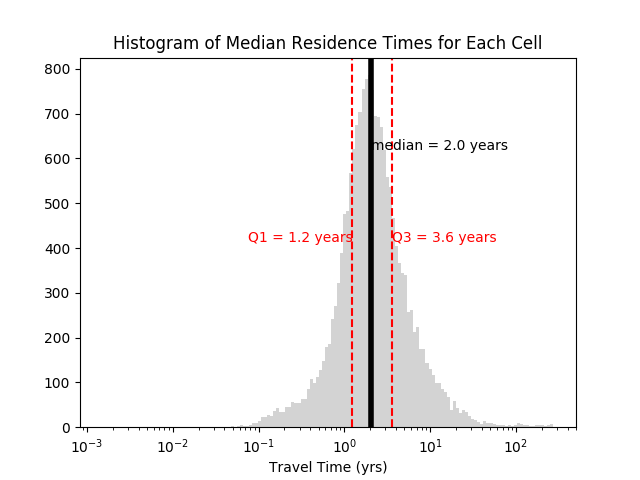

In [19]:
timeCutOff = 1e5
_, bins = np.histogram(np.log10([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff]), bins='auto')
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.hist([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff], bins=10**bins, color="lightgray");
plt.xlabel('Travel Time (yrs)')
ax.set_title('Histogram of Median Residence Times for Each Cell')
ax.axvline(x=np.nanpercentile([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff],25), color='r', linestyle="dashed")
ax.text(np.nanpercentile([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff],25),0.5,'Q1 = %0.1f years'%(float(np.nanpercentile([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff],25))),horizontalalignment='right', color='r',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanmedian([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff]), color='black', linewidth=4)
ax.text(np.nanmedian([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff]),0.75,'median = %0.1f years'%(float(np.nanmedian([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff]))),color='black',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanpercentile([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff],75), color='r', linestyle="dashed")
ax.text(np.nanpercentile([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff],75),0.5,'Q3 = %0.1f years'%(float(np.nanpercentile([float(x)/365 for x in traveltimes_dis_temp["medTime_days"] if float(x) < timeCutOff],75))),horizontalalignment='left', color='r',transform = ax.get_xaxis_transform())
plt.show()

In [20]:
#add the travel time info to the model_grid
traveltimesDF = pd.DataFrame(traveltimes_dis)
model_grid2 = pd.merge(model_grid,traveltimesDF,left_on=['row','col'], right_on=['i','j'], how="left")
model_grid2['medTime_yrs'] = model_grid2['medTime_days']/365.

#resave the model grid
model_grid2.to_csv(model_file.replace("model_grid","model_grid2"))

In [21]:
#plot the coastal discharge travel times
coastalTravelTimesDF = pd.DataFrame(ep_all_temp)
coastalTravelTimesDF['finaltimeYrs'] = coastalTravelTimesDF.finaltime/365.0
coastalTravelTimesDF['discharge_zone'] = ""
if direction=="backward":
    coastalTravelTimesDF.discharge_zone=coastalTravelTimesDF.initialzone
elif direction=="forward":
    coastalTravelTimesDF.discharge_zone=coastalTravelTimesDF.finalzone
coastalTravelTimesDF = coastalTravelTimesDF[coastalTravelTimesDF.discharge_zone>2000]
# test = [[row.finaltimeYrs] * row.q_int for row in coastalTravelTimesDF2.itertuples() if row.q_int>0]
# coastalTravelTimesLst = [x for sublist in test for x in sublist]
coastalTravelTimesLst = [x for x in coastalTravelTimesDF.finaltimeYrs]


In [22]:
#plot the septic discharge travel times
septicTravelTimesDF = pd.DataFrame(ep_all_temp)
septicTravelTimesDF['finaltimeYrs'] = septicTravelTimesDF.finaltime/365.0
septicTravelTimesDF['discharge_zone'] = ""
if direction=="backward":
    septicTravelTimesDF2 = pd.merge(septicTravelTimesDF,model_grid,right_on=['row','col'], left_on=['i0','j0'], how="left")
    septicTravelTimesDF2.discharge_zone=septicTravelTimesDF2.initialzone
elif direction=="forward":
    septicTravelTimesDF2 = pd.merge(septicTravelTimesDF,model_grid,right_on=['row','col'], left_on=['i','j'], how="left")
    septicTravelTimesDF2.discharge_zone=septicTravelTimesDF2.finalzone
septicTravelTimesDF2 = septicTravelTimesDF2[(septicTravelTimesDF2.sewer==0) & (septicTravelTimesDF2.ibound==1) & (septicTravelTimesDF2.population>0)]
# test = [[row.finaltimeYrs] * row.q_int for row in septicTravelTimesDF2.itertuples() if row.q_int>0]
septicTravelTimesLst = [x for x in septicTravelTimesDF2.finaltimeYrs]


In [23]:
#plot the coastal septic discharge travel times
coastalsepticTravelTimesDF = septicTravelTimesDF2[septicTravelTimesDF2.discharge_zone>2000]
# test = [[row.finaltimeYrs] * row.q_int for row in coastalsepticTravelTimesDF.itertuples() if row.q_int>0]
coastalsepticTravelTimesLst = [x for x in coastalsepticTravelTimesDF.finaltimeYrs]

In [24]:
from scipy import stats
print(stats.describe(septicTravelTimesLst))
print(stats.describe(coastalsepticTravelTimesLst))

DescribeResult(nobs=179917, minmax=(0.00013557798, 44952.492), mean=35.352108, variance=497928.28, skewness=44.61675262451172, kurtosis=2290.5017181559924)
DescribeResult(nobs=8649, minmax=(0.015524981, 44952.492), mean=640.258, variance=9973388.0, skewness=9.773609161376953, kurtosis=108.23559550863719)


<IPython.core.display.Javascript object>


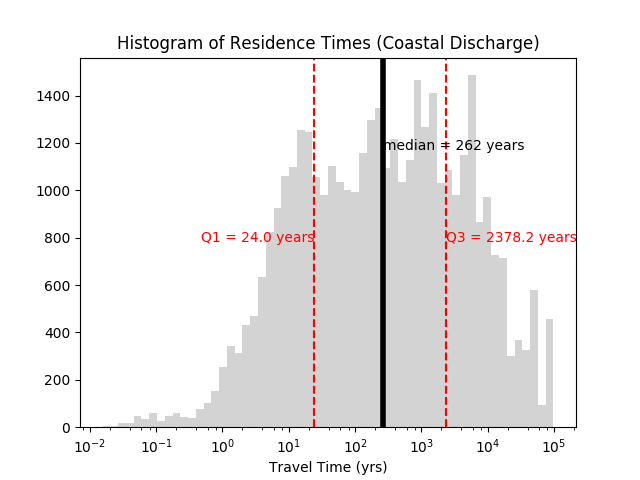

In [25]:
timeCutOff = 1e5
_, bins = np.histogram(np.log10([x for x in coastalTravelTimesLst if x < timeCutOff]), bins='auto')
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.hist([x for x in coastalTravelTimesLst if x < timeCutOff], bins=10**bins, color="lightgray");
ax.set_xscale("log")
plt.xlabel('Travel Time (yrs)')
ax.set_title('Histogram of Residence Times (Coastal Discharge)')
#plt.xlim([0,100])
#plt.axvline(x=25, color='r')
#plt.text(15,775,'25 years',color='r', horizontalalignment="right")

ax.axvline(x=np.nanpercentile([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff],25), color='r', linestyle="dashed")
ax.text(np.nanpercentile([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff],25),0.5,'Q1 = %0.1f years'%(float(np.nanpercentile([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff],25))),horizontalalignment='right', color='r',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanmedian([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff]), color='black', linewidth=4)
ax.text(np.nanmedian([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff]),0.75,'median = %i years'%(int(np.nanmedian([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff]))),color='black',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanpercentile([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff],75), color='r', linestyle="dashed")
ax.text(np.nanpercentile([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff],75),0.5,'Q3 = %0.1f years'%(float(np.nanpercentile([x for x in [x for x in coastalTravelTimesLst if x < timeCutOff] if x < timeCutOff],75))),horizontalalignment='left', color='r',transform = ax.get_xaxis_transform())
plt.show()

<IPython.core.display.Javascript object>


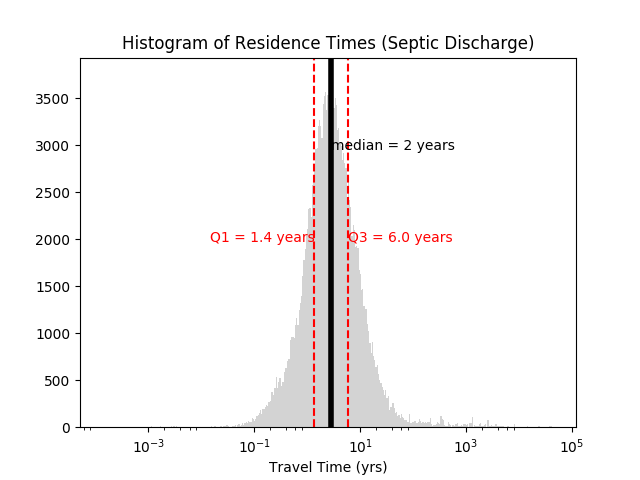

In [26]:
timeCutOff = 1e5
_, bins = np.histogram(np.log10([x for x in septicTravelTimesLst if x < timeCutOff]), bins='auto')
fig,ax  = plt.subplots()
ax.set_xscale("log")
ax.hist([x for x in septicTravelTimesLst if x < timeCutOff], bins=10**bins, color="lightgray");

plt.xlabel('Travel Time (yrs)')
ax.set_title('Histogram of Residence Times (Septic Discharge)')


ax.axvline(x=np.nanpercentile([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff],25), color='r', linestyle='dashed')
ax.text(np.nanpercentile([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff],25),0.5,'Q1 = %0.1f years'%(float(np.nanpercentile([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff],25))),horizontalalignment='right', color='r',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanmedian([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff]), color='black', linewidth=4)
ax.text(np.nanmedian([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff]),0.75,'median = %i years'%(int(np.nanmedian([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff]))),color='black',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanpercentile([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff],75), color='r', linestyle='dashed')
ax.text(np.nanpercentile([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff],75),0.5,'Q3 = %0.1f years'%(float(np.nanpercentile([x for x in [x for x in septicTravelTimesLst if x < timeCutOff] if x < timeCutOff],75))),horizontalalignment='left', color='r',transform = ax.get_xaxis_transform())
plt.show()

<IPython.core.display.Javascript object>


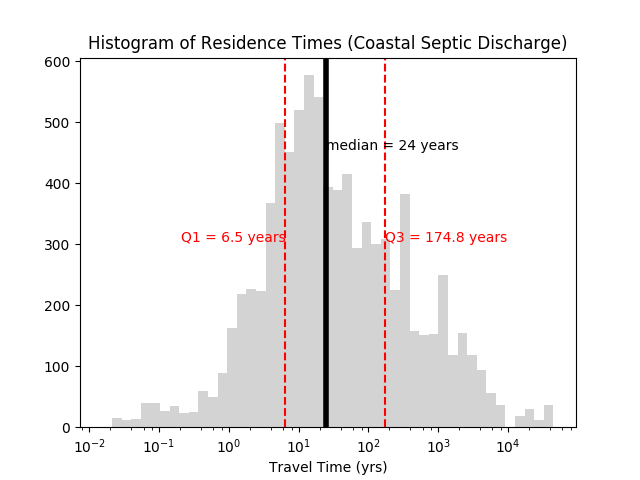

In [27]:
timeCutOff = 1e5
_, bins = np.histogram(np.log10([x for x in coastalsepticTravelTimesLst if x < timeCutOff]), bins='auto')
fig,ax  = plt.subplots()
ax.set_xscale("log")
ax.hist([x for x in coastalsepticTravelTimesLst if x < timeCutOff], bins=10**bins, color="lightgray");

plt.xlabel('Travel Time (yrs)')
ax.set_title('Histogram of Residence Times (Coastal Septic Discharge)')


ax.axvline(x=np.nanpercentile([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff],25), color='r', linestyle='dashed')
ax.text(np.nanpercentile([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff],25),0.5,'Q1 = %0.1f years'%(float(np.nanpercentile([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff],25))),horizontalalignment='right', color='r',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanmedian([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff]), color='black', linewidth=4)
ax.text(np.nanmedian([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff]),0.75,'median = %i years'%(int(np.nanmedian([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff]))),color='black',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanpercentile([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff],75), color='r', linestyle='dashed')
ax.text(np.nanpercentile([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff],75),0.5,'Q3 = %0.1f years'%(float(np.nanpercentile([x for x in [x for x in coastalsepticTravelTimesLst if x < timeCutOff] if x < timeCutOff],75))),horizontalalignment='left', color='r',transform = ax.get_xaxis_transform())
plt.show()

<IPython.core.display.Javascript object>


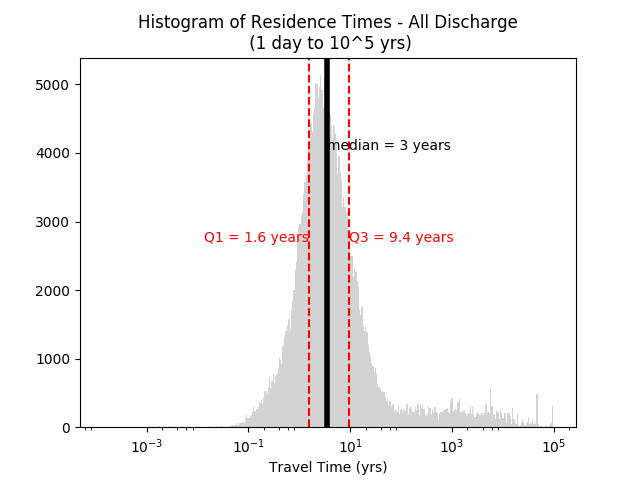

In [28]:
timeCutOff = 1e5
_, bins = np.histogram(np.log10([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff]), bins='auto')
fig,ax  = plt.subplots()
ax.set_xscale("log")
ax.hist([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff], bins=10**bins, color="lightgray");

plt.xlabel('Travel Time (yrs)')
ax.set_title('Histogram of Residence Times - All Discharge\n (1 day to 10^5 yrs)')
#plt.xlim([0,100])
ax.axvline(x=np.nanpercentile([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff],25), color='r', linestyle='dashed')
ax.text(np.nanpercentile([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff],25),0.5,'Q1 = %0.1f years'%(float(np.nanpercentile([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff],25))),horizontalalignment='right', color='r',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanmedian([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff]), color='black', linewidth=4)
ax.text(np.nanmedian([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff]),0.75,'median = %i years'%(int(np.nanmedian([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff]))),color='black',transform = ax.get_xaxis_transform())
ax.axvline(x=np.nanpercentile([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff],75), color='r', linestyle='dashed')
ax.text(np.nanpercentile([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff],75),0.5,'Q3 = %0.1f years'%(float(np.nanpercentile([x for x in ep_all_temp["finaltime"]/365 if x < timeCutOff],75))),horizontalalignment='left', color='r',transform = ax.get_xaxis_transform())
plt.show()

get the median travel time by zone

In [29]:
epDF = pd.DataFrame(ep_all)
#if the direction is backward, then need to switch the final and initial zone
if direction=='forward':
    epDF['dischargeZone']=epDF['finalzone']
elif direction=="backward":
    epDF['dischargeZone']=epDF['initialzone']
epDF['dischargeZone_type']=""
epDF.loc[epDF.dischargeZone<=2000,"dischargeZone_type"]="Non-coastal"
epDF.loc[epDF.dischargeZone>2000,"dischargeZone_type"]="Coastal"
epDF['finalzone_base']=0
epDF.loc[epDF.dischargeZone<=2000,"dischargeZone_base"]=epDF.loc[epDF.dischargeZone<=2000,"dischargeZone"]-1000
epDF.loc[epDF.dischargeZone>2000,"dischargeZone_base"]=epDF.loc[epDF.dischargeZone>2000,"dischargeZone"]-2000

aggregations = {
    'finaltime':{
        'Q1_yrs': lambda x: np.nanpercentile(x,25)/365,
        'median_yrs': lambda x: np.nanmedian(x)/365,
        'Q3_yrs': lambda x: np.nanpercentile(x,75)/365,
        'PartCount': "count"
    }
}

groupColList = ['dischargeZone_base', 'dischargeZone_type']
epDF_zoneSum_All = epDF.groupby('dischargeZone_base').agg(aggregations)
epDF_zoneSum_Coast = epDF.groupby(groupColList).agg(aggregations)
epDF_zoneSum_Coast.columns = epDF_zoneSum_Coast.columns.droplevel()
epDF_zoneSum_Coast.reset_index(inplace=True)
epDF_zoneSum_Noncoast = epDF_zoneSum_Coast.loc[epDF_zoneSum_Coast.dischargeZone_type=='Non-coastal',:]
epDF_zoneSum_Coast = epDF_zoneSum_Coast.loc[epDF_zoneSum_Coast.dischargeZone_type=='Coastal',:]

colList = []
for thisagg in epDF_zoneSum_Coast.columns:
    if thisagg in groupColList:
        colList.append(thisagg)
    else:
        colList.append("Coast_%s"%(thisagg))
epDF_zoneSum_Coast.columns = colList

colList = []
for thisagg in epDF_zoneSum_Noncoast.columns:
    if thisagg in groupColList:
        colList.append(thisagg)
    else:
        colList.append("Noncoast_%s"%(thisagg))
epDF_zoneSum_Noncoast.columns = colList

epDF_zoneSum_Noncoast.drop("dischargeZone_type",1, inplace=True)
epDF_zoneSum_Coast.drop("dischargeZone_type",1, inplace=True)

epDF_zoneSum_All.columns = epDF_zoneSum_All.columns.droplevel()
epDF_zoneSum_All.reset_index(inplace=True)

epDF_zoneSum_All = epDF_zoneSum_All.merge(epDF_zoneSum_Coast,"left",on='dischargeZone_base')
epDF_zoneSum_All = epDF_zoneSum_All.merge(epDF_zoneSum_Noncoast,"left",on='dischargeZone_base')

#add in the coastal and non-coastal data


f_out = os.path.join(model_ws, 'TravelTimeSummary_%s_Zones.csv'%(direction))
epDF_zoneSum_All.to_csv(f_out)

In [30]:
# epTemp = epDF.groupby(['i0','j0'], as_index=False).count()

In [31]:
# epTemp.to_csv(os.path.join(model_ws,"partNumStartTest.csv"))